In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.fft import fft


def calculate_lyapunov_exponent(x, y, t):
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    log_distances = np.log(distances + 1e-10)
    time_diffs = np.diff(t)
    return np.mean(log_distances / (time_diffs + 1e-10))
        

def calculate_spectral_entropy(signal, sampling_rate=1):
    try:
        power_spectrum = np.abs(np.fft.fft(signal))**2
        power_spectrum /= np.sum(power_spectrum)
        spectral_entropy = -np.sum(power_spectrum * np.log2(power_spectrum + 1e-10))
        return spectral_entropy
    except Exception as e:
        return 0.0

def calculate_dominant_frequency(signal, sampling_rate=1):
    try:
        fft_vals = np.fft.fft(signal)
        fft_freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
        positive_freqs = fft_freqs[fft_freqs > 0]
        positive_amplitudes = np.abs(fft_vals[fft_freqs > 0])
        dominant_freq = positive_freqs[np.argmax(positive_amplitudes)] if len(positive_freqs) > 0 else 0.0
        return dominant_freq
    except Exception as e:
        return 0.0


def validate_input_lengths(x, y, t):
    if len(x)<len(t):
        n=len(t)-len(x)
        t = t[:len(t)-n]
        return {'x':x,'y':y,'t':t}
    if len(x)>len(t):
        n=len(x)-len(t)
        t.extend([t[-1]]*n)
        return {'x':x,'y':y,'t':t}
    return {'x':x,'y':y,'t':t}



def calculate_features_for_segment(x,y,t):

    total_distance = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    linear_distance = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    linearity = linear_distance / total_distance if total_distance > 0 else 0

    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    time_diffs = np.diff(t)

    with np.errstate(divide='ignore', invalid='ignore'):
        velocities = np.where(time_diffs > 0, distances / time_diffs, 0)
    velocity_variance = np.var(velocities) if len(velocities) > 0 else 0

    lyapunov_exponent=calculate_lyapunov_exponent(x,y,t)
    dominant_frequency=calculate_dominant_frequency(velocities)
    spectral_entropy=calculate_spectral_entropy(velocities)

    features = {
        "linearity": linearity,
        "velocity_variance": velocity_variance,
        "lyapunov_exponent": lyapunov_exponent,
        "dominant_frequency": dominant_frequency,
        "spectral_entropy": spectral_entropy
    }
    return features


def calculate_features_for_trajectory(x, y, t):
    valid=validate_input_lengths(x, y, t)
    x,y,t=valid['x'],valid['y'],valid['t']

    trajectory_features=calculate_features_for_segment(x,y,t)

    return trajectory_features



In [3]:
human_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\humans\mouse_movements_humans.json',lines=True)
abot_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\bots\mouse_movements_advanced_bots.json',lines=True)
mbot_df = pd.read_json(r'.\web_bot_detection_dataset\phase2\data\mouse_movements\bots\mouse_movements_moderate_bots.json',lines=True)

In [5]:
human_df["label"]="human"
abot_df["label"]="abot"
mbot_df["label"]="mbot"

In [7]:
df=pd.concat([human_df, abot_df, mbot_df], axis=0,ignore_index=True)

In [9]:
df["X"]=df.apply(lambda x: [int(i.split('(')[1].split(',')[0]) for i in re.findall("m[(][0-9,]*[)]",re.sub("c.?[(][0-9,]*[)]","m(9999,9999)",x['mousemove_total_behaviour']))],axis=1)
df["Y"]=df.apply(lambda x: [int(i.split(',')[1].split(')')[0]) for i in re.findall("m[(][0-9,]*[)]",re.sub("c.?[(][0-9,]*[)]","m(9999,9999)",x['mousemove_total_behaviour']))],axis=1)

In [11]:
df['mousemove_times']=df.apply(lambda s: [int(x) for x in s['mousemove_times'].split(',')[:-1]],axis="columns")
df['mousemove_times']=df.apply(lambda s: np.delete(np.array(s['mousemove_times']), np.where(np.array(s['X']) == 9999)[0]).tolist(),axis="columns")

In [13]:
df['X']=df.apply(lambda s: [x for x in s['X'] if x != 9999],axis="columns")
df['Y']=df.apply(lambda s: [x for x in s['Y'] if x != 9999],axis="columns")

In [15]:
df[["linearity","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]] = df.apply(lambda row: calculate_features_for_trajectory(row['X'],row['Y'],row['mousemove_times']), axis='columns', result_type='expand')

In [17]:
df2 = df[["label","linearity","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()
df2

,label,linearity,velocity_variance,lyapunov_exponent,dominant_frequency,spectral_entropy
0,human,0.000717,1.427084,2.086806e+06,0.006689,11.657955
1,human,0.004703,1.409959,9.621087e-02,0.001437,9.311405
2,human,0.000209,1.096157,1.049096e-01,0.018718,10.224978
3,human,0.002436,0.503125,7.261330e-02,0.003790,10.608845
4,human,0.003372,1.755606,3.932160e+06,0.001561,9.528536
...,...,...,...,...,...,...
294,mbot,0.016206,0.000555,-3.653414e-03,0.000529,1.833754
295,mbot,0.015851,0.001012,-1.470289e-03,0.001169,2.704549
296,mbot,0.137613,0.000401,1.828426e-03,0.000135,1.379502
297,mbot,0.176857,0.000260,-8.905345e-04,0.000270,1.056784


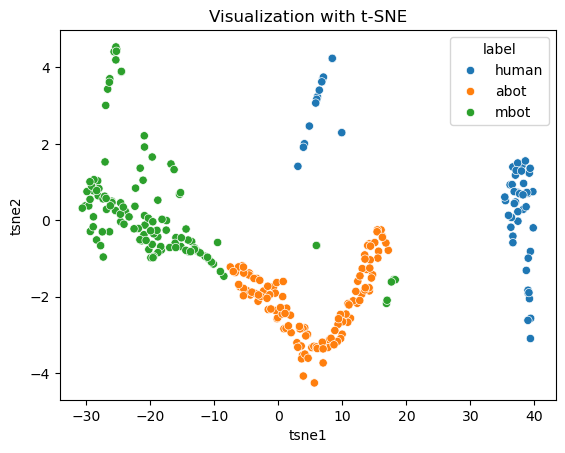

In [19]:
import seaborn as sns
features = df2.columns.difference(['label'])

X = df2[features]
y = df2['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df2['tsne1'] = tsne_result[:, 0]
df2['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df2)
plt.title('Visualization with t-SNE')
plt.show()

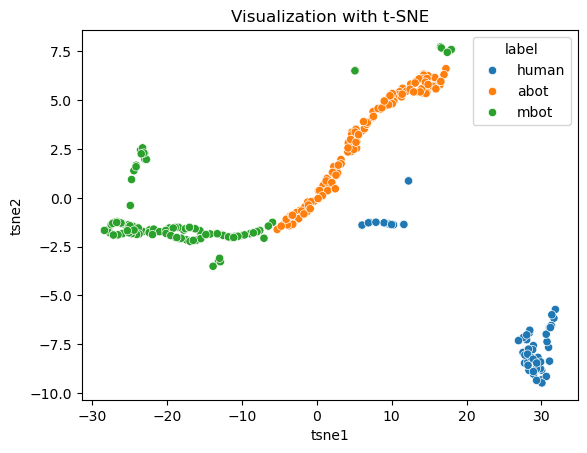

In [21]:
df3 = df[["label","velocity_variance","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()

features = df3.columns.difference(['label'])

X = df3[features]
y = df3['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df3['tsne1'] = tsne_result[:, 0]
df3['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df3)
plt.title('Visualization with t-SNE')
plt.show()

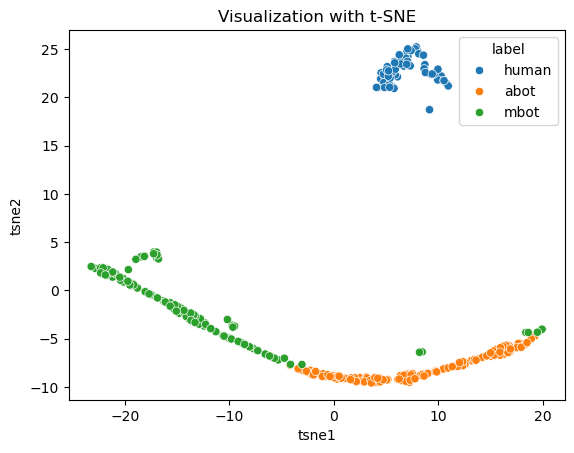

In [23]:
df4 = df[["label","velocity_variance","dominant_frequency","spectral_entropy"]].copy()

features = df4.columns.difference(['label'])
X = df4[features]
y = df4['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df4['tsne1'] = tsne_result[:, 0]
df4['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df4)
plt.title('Visualization with t-SNE')
plt.show()

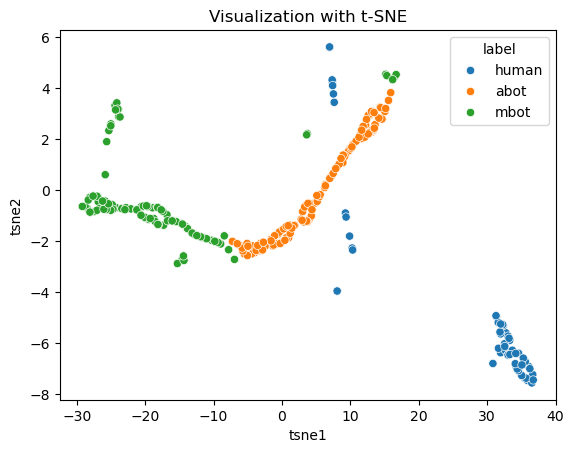

In [25]:
df5 = df[["label","lyapunov_exponent","dominant_frequency","spectral_entropy"]].copy()

features = df5.columns.difference(['label'])
X = df5[features]
y = df5['label']


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
df5['tsne1'] = tsne_result[:, 0]
df5['tsne2'] = tsne_result[:, 1]

sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df5)
plt.title('Visualization with t-SNE')
plt.show()